# **Database Schema**

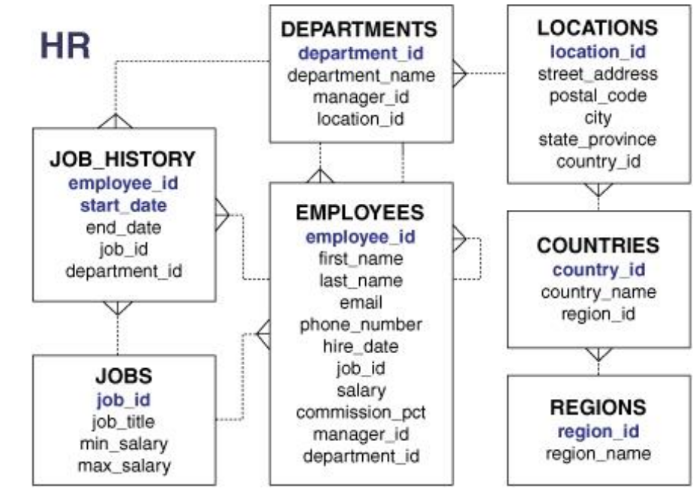

**SQL Query to create Schema**



*    Employees table CREATE TABLE Employees ( employee_id INT PRIMARY KEY, first_name VARCHAR(50), last_name VARCHAR(50), email VARCHAR(100), phone_number VARCHAR(20), hire_date DATE, job_id INT, salary DECIMAL(10, 2), commission_pct DECIMAL(4, 2), manager_id INT, department_id INT );
*   Departments table CREATE TABLE Departments ( department_id INT PRIMARY KEY, department_name VARCHAR(100), manager_id INT, location_id INT );

*   Locations table CREATE TABLE Locations ( location_id INT PRIMARY KEY, street_address VARCHAR(255), postal_code VARCHAR(20), city VARCHAR(100), state_province VARCHAR(100), country_id INT );
*   Countries table CREATE TABLE Countries ( country_id INT PRIMARY KEY, country_name VARCHAR(100), region_id INT );

* Regions table CREATE TABLE Regions ( region_id INT PRIMARY KEY, region_name VARCHAR(100) );

*   Job_history table CREATE TABLE Job_history ( employee_id INT, start_date DATE, end_date DATE, job_id INT, department_id INT );
*   Jobs table CREATE TABLE Jobs ( job_id INT PRIMARY KEY, job_title VARCHAR(100), min_salary DECIMAL(10, 2), max_salary DECIMAL(10, 2) );





# API KEY Setup

In [1]:
# from google.colab import userdata
API_KEY="add you own key"

# Necessary installations and mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


# Convert Json file to Jsonl

In [ ]:
import json

# Load the JSON file
with open('//content/QryGPT.json', 'r') as file:
    data = json.load(file)

# Write JSONL format to a new file
with open('QryGPT_output.jsonl', 'w') as file:
    # Write system message
    if 'system_message' in data:
        file.write(json.dumps({"system_message": data['system_message']}))
        file.write('\n')

    # Write examples in JSONL format
    for example in data['examples']:
        file.write(json.dumps(example))
        file.write('\n')


In [ ]:
# Load the JSON file
with open('/content/drive/MyDrive/GenAI GPT/QryGPT_Testing.json', 'r') as file:
    data = json.load(file)

# Write JSONL format to a new file
with open('QryGPT_Testing.jsonl', 'w') as file:
    # Write system message
    if 'system_message' in data:
        file.write(json.dumps({"system_message": data['system_message']}))
        file.write('\n')

    # Write examples in JSONL format
    for example in data['examples']:
        file.write(json.dumps(example))
        file.write('\n')

# Data preparation and analysis for chat model

In [ ]:
pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:00


In [ ]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

In [ ]:
data_path = "/content/drive/MyDrive/GenAI GPT/data.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 55
First example:
{'role': 'system', 'content': 'You are an assistant that is an expert in generating SQL queries. Having the access to database content, generate a correct SQL query for the given question. ### Database content ### -- Employees table CREATE TABLE Employees ( employee_id INT PRIMARY KEY, first_name VARCHAR(50), last_name VARCHAR(50), email VARCHAR(100), phone_number VARCHAR(20), hire_date DATE, job_id INT, salary DECIMAL(10, 2), commission_pct DECIMAL(4, 2), manager_id INT, department_id INT ); -- Departments table CREATE TABLE Departments ( department_id INT PRIMARY KEY, department_name VARCHAR(100), manager_id INT, location_id INT ); -- Locations table CREATE TABLE Locations ( location_id INT PRIMARY KEY, street_address VARCHAR(255), postal_code VARCHAR(20), city VARCHAR(100), state_province VARCHAR(100), country_id INT ); -- Countries table CREATE TABLE Countries ( country_id INT PRIMARY KEY, country_name VARCHAR(100), region_id INT ); -- Regions table 

In [ ]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        function_call = message.get("function_call", None)

        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


**Token Counting Utilities**

In [ ]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [ ]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 378, 607
mean / median: 466.4, 455.0
p5 / p95: 411.4, 548.6

#### Distribution of num_assistant_tokens_per_example:
min / max: 10, 125
mean / median: 53.527272727272724, 48.0
p5 / p95: 23.6, 82.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


**Cost Estimation**

In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~25652 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~76956 tokens


# Fine Tuning

Upload a training file

In [4]:
import openai
# openai.api_key=""

In [5]:
from openai import OpenAI
client = OpenAI(api_key=API_KEY)

client.files.create(
  file=open(data_path, "rb"),
  purpose="fine-tune"
)

NameError: name 'data_path' is not defined

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=API_KEY)

client.fine_tuning.jobs.create(
  training_file="file-qF9fRY7kodQzbfoY6EyJfgUu",
  model="gpt-3.5-turbo"
)

FineTuningJob(id='ftjob-RBpXurFDhQEY6Pz51mDamvZf', created_at=1716840196, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-hycV8ansPoQo5i3OySgzPdnz', result_files=[], seed=513244575, status='validating_files', trained_tokens=None, training_file='file-qF9fRY7kodQzbfoY6EyJfgUu', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

# Use a Finetuned model

In [ ]:
# Q: Please provide detailed information for precise sql query
# Q: Fetch data from employees table where salary is more than 15k
# Q: Fetch data from department where manager_id is null
# Q: Fetch the employee where employee first name start with letter 'S'
# Q: Select all the employees where department is finance


In [6]:
schema='''Employees table CREATE TABLE Employees ( employee_id INT PRIMARY KEY, first_name VARCHAR(50), last_name VARCHAR(50),email VARCHAR(100), phone_number VARCHAR(20), hire_date DATE, job_id INT, salary DECIMAL(10, 2), commission_pct DECIMAL(4, 2), manager_id INT, department_id INT ); -- Departments table CREATE TABLE Departments ( department_id INT PRIMARY KEY, department_name VARCHAR(100), manager_id INT, location_id INT ); -- Locations table CREATE TABLE Locations ( location_id INT PRIMARY KEY, street_address VARCHAR(255), postal_code VARCHAR(20), city VARCHAR(100), state_province VARCHAR(100), country_id INT ); -- Countries table CREATE TABLE Countries ( country_id INT PRIMARY KEY, country_name VARCHAR(100), region_id INT ); -- Regions table CREATE TABLE Regions ( region_id INT PRIMARY KEY, region_name VARCHAR(100) ); -- Job_history table CREATE TABLE Job_history ( employee_id INT, start_date DATE, end_date DATE, job_id INT, department_id INT ); -- Jobs table CREATE TABLE Jobs ( job_id INT PRIMARY KEY, job_title VARCHAR(100), min_salary DECIMAL(10, 2), max_salary DECIMAL(10, 2) );" '''

In [7]:
base_prompt='''You are an helpful assistant that is an expert in generating SQL queries. Having the access to database content, Generate information about the database content, generate a correct SQL query for the given question and also generate synthetic data based on the below database content. Also, while generating sythetic data return the data in a tabular format only.

Database content:{0}

If you are not sure about the accuracy of the SQL Query, just respond that “Please provide detailed information for precise sql query.”'''

system_prompt = base_prompt.format(schema)
print(system_prompt)

You are an helpful assistant that is an expert in generating SQL queries. Having the access to database content, Generate information about the database content, generate a correct SQL query for the given question and also generate synthetic data based on the below database content. Also, while generating sythetic data return the data in a tabular format only.

Database content:Employees table CREATE TABLE Employees ( employee_id INT PRIMARY KEY, first_name VARCHAR(50), last_name VARCHAR(50),email VARCHAR(100), phone_number VARCHAR(20), hire_date DATE, job_id INT, salary DECIMAL(10, 2), commission_pct DECIMAL(4, 2), manager_id INT, department_id INT ); -- Departments table CREATE TABLE Departments ( department_id INT PRIMARY KEY, department_name VARCHAR(100), manager_id INT, location_id INT ); -- Locations table CREATE TABLE Locations ( location_id INT PRIMARY KEY, street_address VARCHAR(255), postal_code VARCHAR(20), city VARCHAR(100), state_province VARCHAR(100), country_id INT ); --

In [8]:
from openai import OpenAI
client = OpenAI(api_key=API_KEY)
max_length=5
i=0

message=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "Tell me about your tables and their column name you have."}
  ]
completion = client.chat.completions.create(
    model="ft:gpt-3.5-turbo-0125:personal:querygpt:9TavrDfX",
    messages=message,
    temperature=0.2
  )
print("SQL Assistant::->",completion.choices[0].message.content)
response=completion.choices[0].message.content
message.append({"role": "assistant", "content": response})

while i<=max_length:

  user_input=input()
  if "exit" in user_input.lower():
    print("Exiting the program, Thank You!")
    break

  message.append({"role": "user", "content": user_input})

  completion = client.chat.completions.create(
    model="ft:gpt-3.5-turbo-0125:personal:querygpt:9TavrDfX",
    messages=message,
    temperature=0.2
  )
  print("SQL Assistant::->",completion.choices[0].message.content)
  response=completion.choices[0].message.content
  message.append({"role": "assistant", "content": response})



In [5]:
# messagefrom openai import OpenAI

import streamlit as st

with st.sidebar:
    openai_api_key = st.text_input("OpenAI API Key", key=API_KEY, type="password")
    "[Get an OpenAI API key](https://platform.openai.com/account/api-keys)"
    "[View the source code](https://github.com/streamlit/llm-examples/blob/main/Chatbot.py)"
    "[![Open in GitHub Codespaces](https://github.com/codespaces/badge.svg)](https://codespaces.new/streamlit/llm-examples?quickstart=1)"

st.title("💬 Citi Bank NA")
st.caption("🚀 A Streamlit chatbot powered by OpenAI")
if "messages" not in st.session_state:
    st.session_state["messages"] = [{"role": "assistant", "content": "How can I help you?"}]

for msg in st.session_state.messages:
    st.chat_message(msg["role"]).write(msg["content"])

if prompt := st.chat_input():
    if not openai_api_key:
        st.info("Please add your OpenAI API key to continue.")
        st.stop()

    client = OpenAI(api_key=openai_api_key)
    st.session_state.messages.append({"role": "user", "content": prompt})
    st.chat_message("user").write(prompt)
    response = client.chat.completions.create(model="gpt-3.5-turbo", messages=st.session_state.messages)
    msg = response.choices[0].message.content
    st.session_state.messages.append({"role": "assistant", "content": msg})
    st.chat_message("assistant").write(msg)

2024-08-28 17:19:46.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-28 17:19:46.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-28 17:19:46.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-28 17:19:46.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-28 17:19:46.598 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-28 17:19:46.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-28 17:19:46.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-08-28 17:19:46.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [1]:
! pip install streamlit openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 6.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.9/423.9 kB 16.9 MB/s eta 0:00:00
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.8/284.8 kB 520.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
